# Wikipedia crawler which collects all the links from given page and also check connection between all of them

Importing all the required libraries 

In [3]:
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup as soup
import re
import pandas as pd
import time,datetime,random
import networkx as nx
import matplotlib.pyplot as plt

urllib is used to make request to open website we want. bs4 is package which will parse the html page and store it so we can access and manipulate it. networkx is package for creating graph from given data.

In [4]:
url = 'https://en.wikipedia.org/wiki/Out_of_the_Shadows_(unfinished_film)'
html = urlopen(url, timeout=(6.05))
bs = soup(html, 'html.parser')
html.close()

We made request to wikipedia page and stored that page using bs4. Since we do not want links from navigation box in wikipedia page we just deleted those divisions using decompose.

In [5]:
try:
    bs.find("div",{"class":"toc"}).decompose()
except AttributeError:
    pass
b = bs.prettify().split("References")[0]
bs1 = soup(b)

Since we want links in the article before reference section not after that, therefore we removing the reference section from variable in which we stored the whole html page.

In [6]:
pages, title = [], []
bs2 = bs1.find("div", {"id":"bodyContent"})
edge_list = pd.DataFrame(columns=['V1','V2'])
for link in bs2.findAll("a",href=
            re.compile("^(/wiki/)((?!:)(?!disambiguation)(?!International_Standard_Book_Number).)*$")):
    if link.attrs['title'] not in title:
        pages.append(link.attrs['href'])
        title.append(link.attrs['title'])

M_art = pd.DataFrame(zip(title,pages),columns=['Article','Link'])
edge_list['V2'], edge_list['V1'] = title, bs.title.text

We are checking every link on given wikipedia article and storing it only if it points to another wikipedia article. We are ignoring some unneccessary links such as ISBN, disambiguation. Our code does not store duplicate links or articles.

In [7]:
pages

['/wiki/A._R._Harwood',
 '/wiki/John_Barnes_(Australian_politician)',
 '/wiki/F.W._Thring',
 '/wiki/Diggers_(1931_film)',
 '/wiki/Spur_of_the_Moment_(1931_film)',
 '/wiki/Isle_of_Intrigue']

We are storing titles of all the articles and making edgelist out of them. Means if one article points to another article there is edge between them(directed). 

In [8]:
for i in pages:
    url = 'https://en.wikipedia.org'+i    
    time.sleep(random.randint(1,2))
    random.seed(datetime.datetime.now())
    html = urlopen(url, timeout=(6.05))
    bs = soup(html, 'html.parser')
    html.close()
    sub_title, sub_pages = [], []
    sub_EL = pd.DataFrame(columns=['V1','V2'])
    for link in bs.find("div", {"id":"bodyContent"}).findAll("a",
                       href=re.compile("^(/wiki/)((?!:)(?!disambiguation).)*$")):	
        if link.attrs['href'] not in sub_pages:
            if link.attrs['title'] in title:
                sub_title.append(link.attrs['title'])
                sub_pages.append(link.attrs['href'])
                
    sub_EL['V2'] = sub_title
    sub_EL['V1'] = bs.title.text.replace(' - Wikipedia', '')
    M_art_sub = pd.DataFrame(zip(sub_title,sub_pages), columns=['Article','Link'])
    M_art = M_art.append(M_art_sub,  ignore_index = True)
    edge_list = edge_list.append(sub_EL, ignore_index = True)

Now we have some links from the page of our choice. Now we have to check connection between all those pages, hence we are going on each of those pages and checking if its pointing to one of its own.

We will againg get more edges from above which we will append to our original edge list

/home/ambir/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/ambir/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


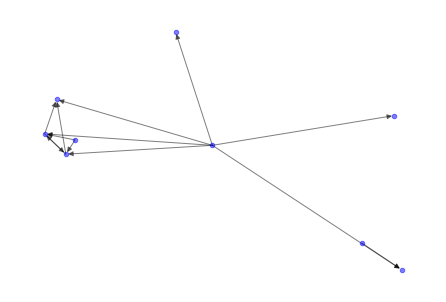

In [9]:
G = nx.DiGraph()
for i in range(len(edge_list)):
     G.add_edge(edge_list.iloc[i,0],edge_list.iloc[i,1])
nx.draw(G, node_size=20, node_color="blue",  alpha=0.5,with_labels = False)
plt.savefig("______.svg", dpi=100)
nx.write_gml(G,'______.gml.gz')
plt.show()

We have a edgelist from which we can construct graph for visulization and calculate its statistical network properties such as degree distribution, clustering coefficient.